## Data Understanding

The bike sharing dataset asks us to predict the bike sharing demand from the 20th days to the end of the month. We are required to predict the total count of bikes rented during each hour covered by the test set.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Importing the datasets that will be used

train_set = pd.read_csv("./archive/train.csv")
test_set = pd.read_csv("./archive/test.csv")

In [3]:
print(f'Train set columns {", ".join(train_set.columns.tolist())}\n')
print(f'Test set columns {", ".join(test_set.columns.tolist())}\n')
print(f'Difference colummns are {set(train_set.columns) - set(test_set.columns)}')

Train set columns datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count

Test set columns datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed

Difference colummns are {'registered', 'casual', 'count'}


#### Notes:
Notice that we have three potential target variables. While the count is the exact predictor, we could calculate the casual and registerd to find the count... we'll see how we will calculate the predictor.

In [4]:
train_set.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
test_set.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [7]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


#### Notes:
- For the training and testing sets, the columns that are avaiable have the same dtype
- The date variable is an object so you will have to change it to a datetype
- The training set has ~10k observations while the test has ~6.5k observations

In [8]:
# Adding the missing columns for the testing columns
test_set['count'] = np.nan
test_set['registered'] = np.nan
test_set['casual'] = np.nan

In [9]:
data = pd.concat([train_set, test_set], axis=0, sort=False)
data.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


#### Notes:
- To analyze the better coherently and apply the data cleaning on both the training and testing set, we will concat the datasets.

## Data Analysis: Feature Enginnering 

#### Notes:
- The following function is a fast.ai function. It will helps automate feature enginnering for datetype
- We will continue to analyze the data to further develop features... for now, we'll deal with the datetype

In [10]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, start_ref=pd.datetime(1900, 1, 1), extra_attr = True):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [11]:
# Using the function "extract_dateinfo" from fast.ai
data = extract_dateinfo(data, 'datetime', drop=False, time=True)

## Data Visualization

In [12]:
def plot_by_hour(x, predictor, year=None, agg='sum'):
    dd = data.copy()
    if year: dd = dd[dd.datetime.dt.year == year]
    
    by_hour = dd.groupby(['Hour', x])[predictor].agg(agg).unstack()
    by_hour.plot(kind='bar', figsize=(15,4), width=0.9, title="Year = {0}".format(year))

def plot_by_year(agg_attr, predictor, title):
    dd = data.copy()    
    by_year = dd.groupby([agg_attr, 'year'])[predictor].agg('sum').unstack()
    return by_year.plot(kind='bar', figsize=(15,5), width=0.9, title=title)

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


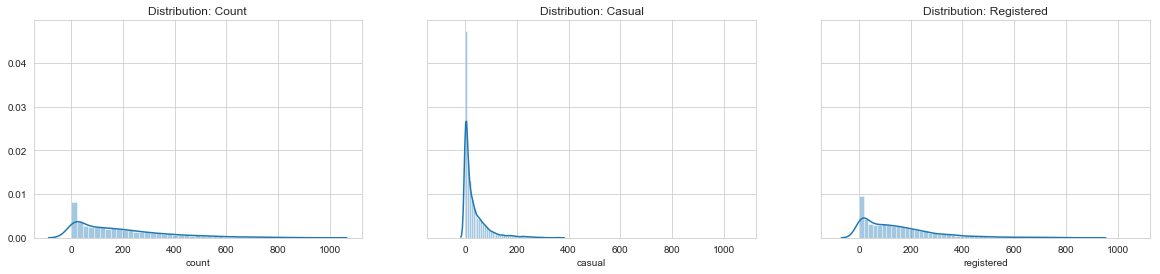

In [13]:
# Visualizing the distribution of our potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 4), sharex=True, sharey=True)
axes = axes.flatten()

sns.distplot(train_set['count'], ax=axes[0])
sns.distplot(train_set['casual'], ax=axes[1])
sns.distplot(train_set['registered'], ax=axes[2])

axes[0].set_title('Distribution: Count')
axes[1].set_title('Distribution: Casual')
axes[2].set_title('Distribution: Registered');

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


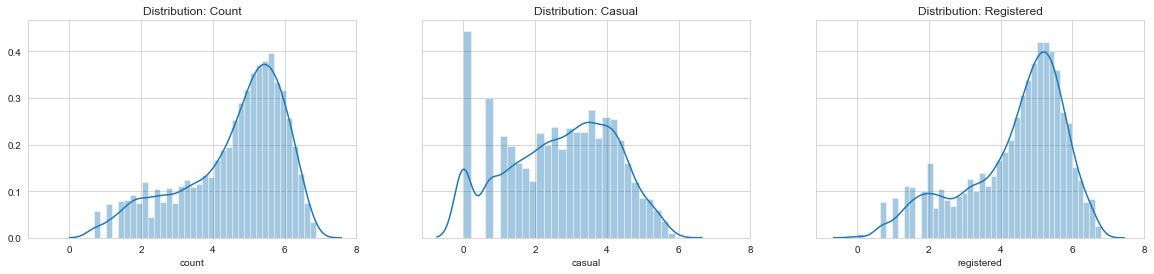

In [14]:
# Visualizing the distribution of our potential target variables

fig, axes = plt.subplots(1, 3, figsize = (20, 4), sharex=True, sharey=True)
axes = axes.flatten()

sns.distplot(np.log1p(train_set['count']), ax=axes[0])
sns.distplot(np.log1p(train_set['casual']), ax=axes[1])
sns.distplot(np.log1p(train_set['registered']), ax=axes[2])

axes[0].set_title('Distribution: Count')
axes[1].set_title('Distribution: Casual')
axes[2].set_title('Distribution: Registered');

#### Notes:
- For casual, the # of bikes being used has a huge spike in the low-end
- For registered, the distribution is more flat (indicating that registered users are more common at a daily level)
- We are better calculating the log.1p to get a normal distribution. 

A logistic distribution better represents the data when the data is highly skewed. For example, if our data contained values like 0, 1, 10, and 100, well our data will be skewed by the 100. When transforming 0, 1, 10, and 100 in a logistic distrbution, we are normalizing the increases from 0, 1, 10, and 100:

```python
log_transform = [np.log1p(i) for i in [0, 1, 10, 100]]
log_transform    
    
# Output: [0.0, 0.6931471805599453, 2.3978952727983707, 4.61512051684126]
```

/Users/alexguanga/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


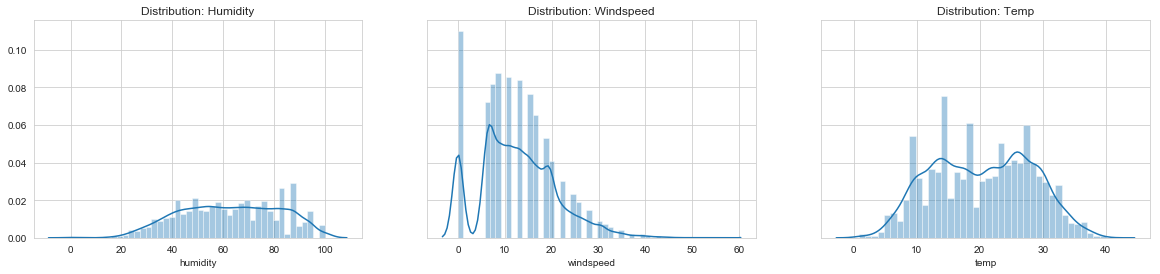

In [15]:
# Lets visualize the distribution of the windspeed, humidity, temp

fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
axes = axes.flatten()

sns.distplot(data['humidity'], ax=axes[0])
sns.distplot(data['windspeed'], ax=axes[1])
sns.distplot(data['temp'], ax=axes[2])

axes[0].set_title('Distribution: Humidity')
axes[1].set_title('Distribution: Windspeed')
axes[2].set_title('Distribution: Temp');

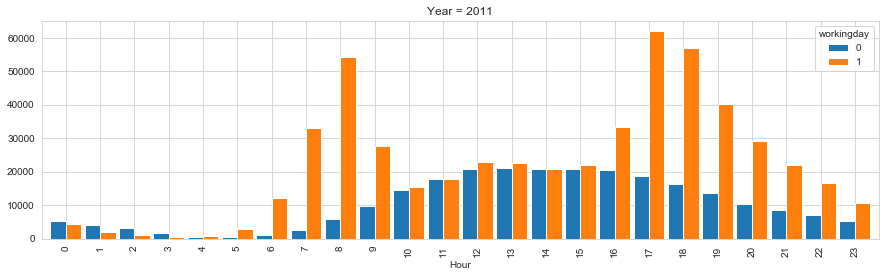

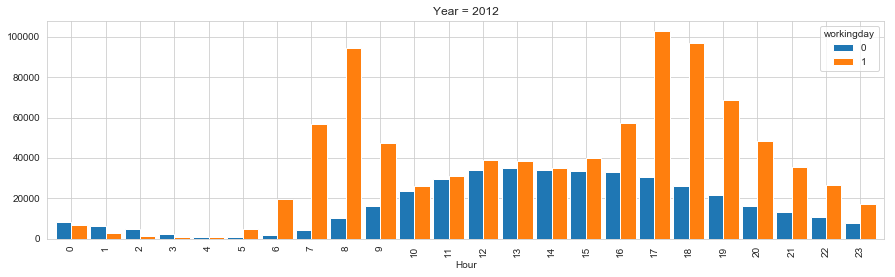

In [16]:
plot_by_hour('workingday', 'count', year=2011)
plot_by_hour('workingday', 'count', year=2012)

#### Notes:
- Notice that we see there is an increase during peak hours in 2011 and 2012. 

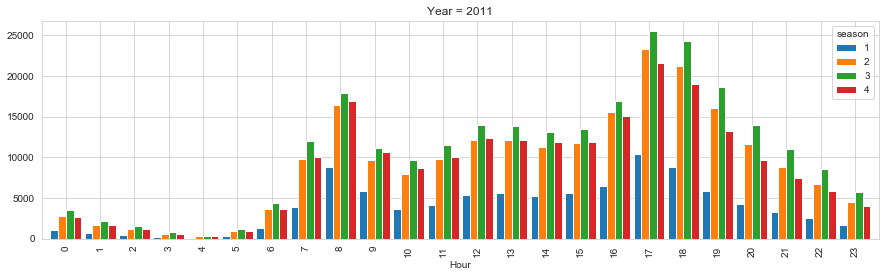

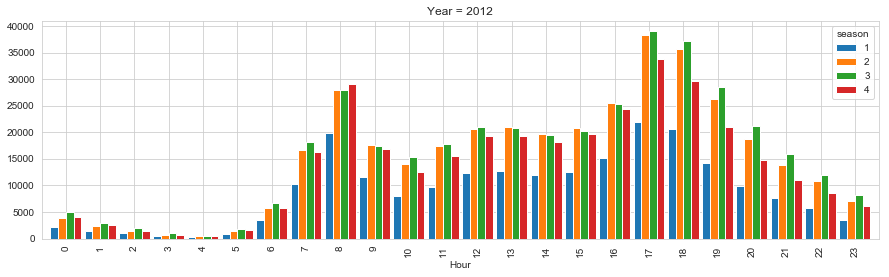

In [17]:
plot_by_hour('season', 'count', year=2011)
plot_by_hour('season', 'count', year=2012)

#### Notes
- Every season has a similar trend except for the spring
-  1 = spring, 2 = summer, 3 = fall, 4 = winter 


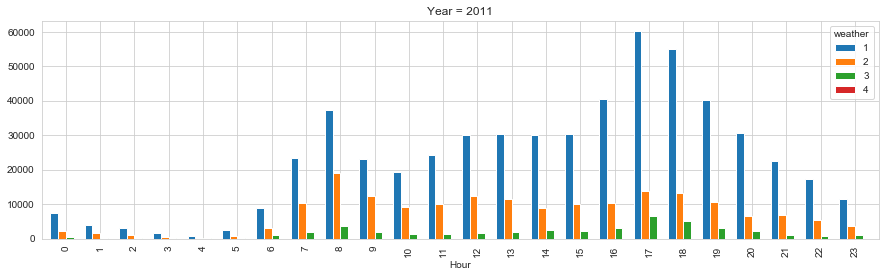

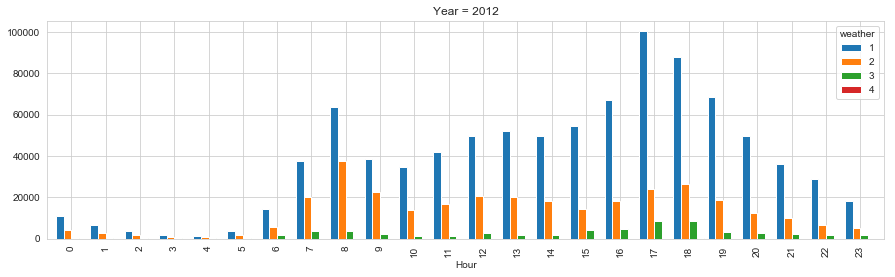

In [18]:
# - weather 
#    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
#    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
#    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
#    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

plot_by_hour('weather', 'count', year=2011)
plot_by_hour('weather', 'count', year=2012)

#### Notes:
- The season and weather visualization states that:
    - All season follow a similar distribution along the x-axis (hours) but spring is has a signficant lesser count
    - A clear weather attracts more people (higher count)

In [19]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Days_in_month', 'is_leap_year', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Hour', 'Minute', 'Second', 'Days_in_year', 'frac_day', 'frac_week',
       'frac_month', 'frac_year', 'Elapsed'],
      dtype='object')

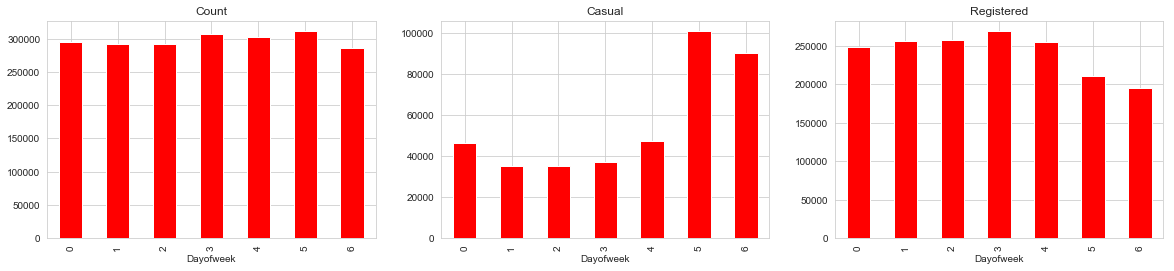

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20, 4))

data.groupby('Dayofweek')['count'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[0])
data.groupby('Dayofweek')['casual'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[1])
data.groupby('Dayofweek')['registered'].sum().sort_index(ascending=True).plot.bar(color='R', ax=axs[2])

axs[0].set_title('Count')
axs[1].set_title('Casual')
axs[2].set_title('Registered');

#### Notes:
- Casual users are more common in the weekend while registered users are more common in the weekdays

## Data Cleaning: Data types

#### Notes
Segmenting the data by their data type can provide further insight how similar data variables are affecting the predictor (y-value) 

In [21]:
data.dtypes.sort_values()

datetime            datetime64[ns]
Is_year_start                 bool
Is_year_end                   bool
Is_quarter_start              bool
Is_quarter_end                bool
Is_month_start                bool
Is_month_end                  bool
is_leap_year                  bool
Days_in_year                 int64
Second                       int64
Minute                       int64
Hour                         int64
Days_in_month                int64
Dayofweek                    int64
Day                          int64
Dayofyear                    int64
Month                        int64
Year                         int64
season                       int64
holiday                      int64
humidity                     int64
workingday                   int64
Week                         int64
weather                      int64
frac_month                 float64
frac_week                  float64
frac_day                   float64
temp                       float64
windspeed           

### Bool Datatype

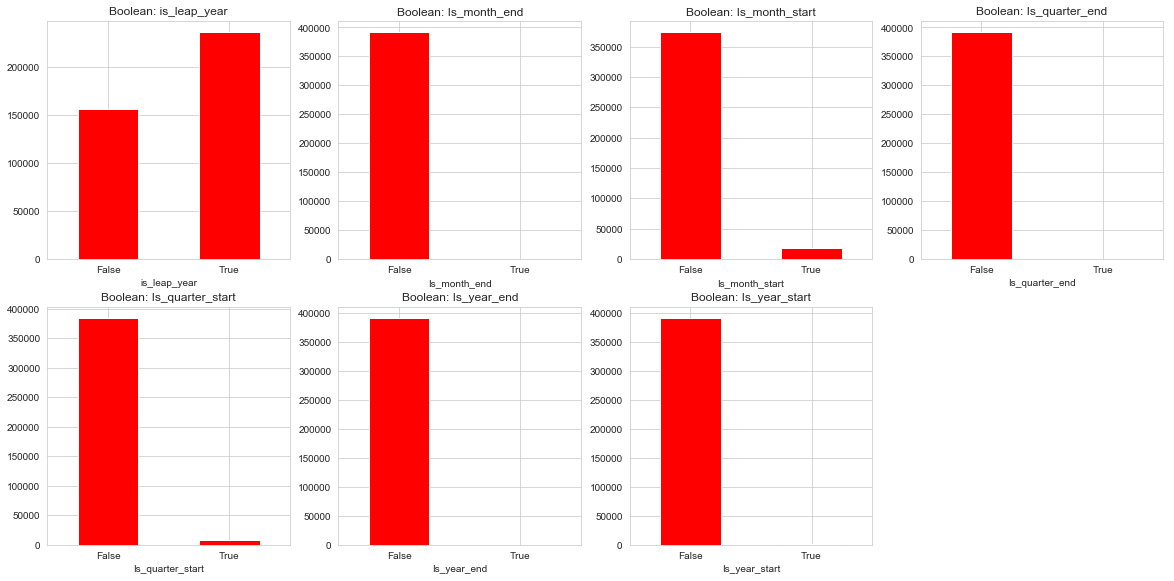

In [22]:
plt.figure(figsize=(20,6))

bool_dtype = data.select_dtypes('bool')

for i, col in enumerate(bool_dtype):
    ax = plt.subplot(3, 4, i + 1)
    data.groupby(col)['casual'].sum().sort_index(ascending=True).plot.bar(color='R', ax=ax)
    plt.title(f'Boolean: {col}')
    plt.xticks(rotation=0)


plt.subplots_adjust(top = 2)   

#### Notes:
- A lot of the boolean variables don't seem to have any value.

In [23]:
# Null/na values for each column
data.apply(lambda x: sum(x.isnull())).sort_values(ascending=False).head(5)

count         6493
registered    6493
casual        6493
Elapsed          0
windspeed        0
dtype: int64

#### Notes:
- The only missing values are derived from the testing set (count, registered, casual)

## Data Analysis: Feature Enginnering

In [24]:
data.columns.sort_values()

Index(['Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'Days_in_year',
       'Elapsed', 'Hour', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Minute', 'Month',
       'Second', 'Week', 'Year', 'atemp', 'casual', 'count', 'datetime',
       'frac_day', 'frac_month', 'frac_week', 'frac_year', 'holiday',
       'humidity', 'is_leap_year', 'registered', 'season', 'temp', 'weather',
       'windspeed', 'workingday'],
      dtype='object')

#### Notes:
- The `custom_extra_dateinfo` is a function that creates variables based on the date.

In [1]:
import calendar

# Conditional on time of day: morning=1, afternoon=2, evening=3, night=4
# Conditional on time of day: spring=1, summer=2, fall=3, winter=4
# Conditional on time of day: clear/few clouds=1, light snow/light rain=2, 
#                             light snow/light rain=3, heavy rain/ice pallets=4

def custom_extra_dateinfo(data):
    data = data.copy()
    data['Year'] = data['Year'].astype('object')
    data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x])
    
    dayofweek_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    data['Dayofweek'] = data['Dayofweek'].map(dayofweek_name)
    data['Weekofyear'] = data['datetime'].dt.weekofyear
    data['Weekend'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [5,6]) else "No")
    
    # Creatinga new column that identifies the time of the day (morning, afternoon, evening)
    time_of_day_conds = [
        ((data['Hour'] >=  5) & (data['Hour'] < 12)),
        ((data['Hour'] >=  12) & (data['Hour'] < 17)),
        ((data['Hour'] >=  17) & (data['Hour'] < 21))]
    time_of_days = ["morning", "afternoon", "evening"]
    data['Timeofday'] = np.select(time_of_day_conds, time_of_days, default="night")
    
    # Creating a T/F boolean variable to check whether if it workday
    data['Rush_Workday'] = data['Dayofweek'].map(lambda x: "Yes" if int(x in [0,1,2,3,4]) else "No")
    
    # Creating a T/F boolean variable to check whether it is rush_hour on a workday
    rush_hours = [8, 9, 10, 16, 17, 18]
    data['Rush_Hour'] = data.apply(lambda x: "Yes" if x['Rush_Workday'] == 1 
                                   and x['hour'] in rush_hours else "No", axis=1)
    
    # Modifying the 'season' column
    seasons_to_rename = {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
    data['season'] = data['season'].map(seasons_to_rename)
    
    # Modifying the 'weather' column
    weather_to_rename = {1: 'clear/few clouds', 2: 'mist/cloudy', 
                         3: 'light snow/light rain', 4: 'heavy rain/ice pallets'}
    data['weather'] = data['weather'].map(weather_to_rename)
        
    return data

In [26]:
data = custom_extra_dateinfo(data)

## Data Correlation

In [27]:
PREDICTORS = ['casual', 'registered', 'count']

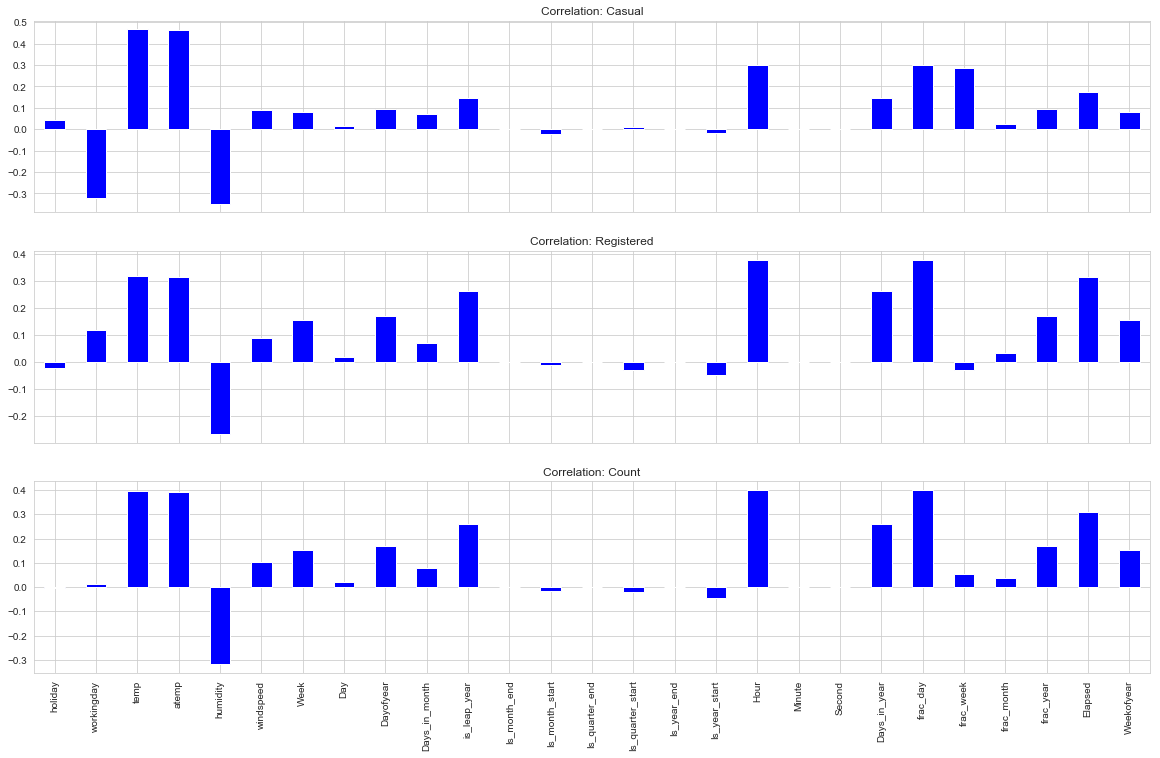

In [28]:
# Correlation among the variables and the potential predictors
corrs = data.corr()

fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)
corrs['casual'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[0], title="Correlation: Casual");
corrs['registered'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[1], title="Correlation: Registered");
corrs['count'].drop(PREDICTORS).plot.bar(color = 'b', ax=axs[2], title="Correlation: Count");

#### Notes:
- The top correlated variables with the predictors are Hour, Days_in_year, frac_day, Elapsed
- The correlation values are similar throughout the three predictors with the exception of workingday

In [29]:
PREDICTORS = ['count', 'registered', 'casual']
#PREDICTORS = ['count_log', 'registered_log', 'casual_log']

def correlation(data, corr_by, remove_by=None, top_values=10):
    data = data.copy()
    corrs = data.corr()
    if remove_by is None: remove_by = [corr_by]     
        
    vals = corrs[corr_by].drop(remove_by).sort_values().values
    col = corrs[corr_by].drop(remove_by).sort_values().index
    
    df = pd.DataFrame({'columns': col, 'values': vals})
    df['abs_vals'] = abs(df['values'])
    
    return df.sort_values(by='abs_vals', ascending=False)[:top_values]

In [30]:
correlation(data, 'casual', remove_by=PREDICTORS)

,columns,values,abs_vals
21,temp,0.467097,0.467097
20,atemp,0.462067,0.462067
0,humidity,-0.348187,0.348187
1,workingday,-0.319111,0.319111
19,Hour,0.302045,0.302045
18,frac_day,0.302045,0.302045
17,frac_week,0.287542,0.287542
16,Elapsed,0.172728,0.172728
15,is_leap_year,0.145241,0.145241
14,Days_in_year,0.145241,0.145241


In [31]:
correlation(data, 'registered', remove_by=PREDICTORS)

,columns,values,abs_vals
21,Hour,0.380540,0.380540
20,frac_day,0.380540,0.380540
19,temp,0.318571,0.318571
18,Elapsed,0.314879,0.314879
17,atemp,0.314635,0.314635
0,humidity,-0.265458,0.265458
16,is_leap_year,0.264265,0.264265
15,Days_in_year,0.264265,0.264265
14,frac_year,0.171237,0.171237
13,Dayofyear,0.170805,0.170805


In [32]:
correlation(data, 'casual', remove_by=PREDICTORS)

,columns,values,abs_vals
21,temp,0.467097,0.467097
20,atemp,0.462067,0.462067
0,humidity,-0.348187,0.348187
1,workingday,-0.319111,0.319111
19,Hour,0.302045,0.302045
18,frac_day,0.302045,0.302045
17,frac_week,0.287542,0.287542
16,Elapsed,0.172728,0.172728
15,is_leap_year,0.145241,0.145241
14,Days_in_year,0.145241,0.145241


## Data Cleaning: Skewness

#### Notes:
- We saw that there are not any missing values other the predictors in the data dataset.
- We need to address boolean values and other categorical values that should be represented with encoders
- Data skewness is an issue in our dataset for the predictors variables.
- We must Q/A all the values to be reassured that the columns in our dataset is not skewed

In [33]:
np.warnings.filterwarnings('ignore')

data['casual_log'] = np.log1p(data['casual'])
data['registered_log'] = np.log1p(data['registered'])
data['count_log'] = np.log1p(data['count'])

data.drop(['casual', 'registered', 'count'], axis=1, inplace=True)

## Data Cleaning: Removing Columns

#### Notes:
- After checking the correlations values, there are a couple of columns that represent the same information. Some of the redudant columns are:
    - Hour and frac_day
    - temp and atemp
    - Days_in_year and is_leap_year

In [34]:
data.drop(['frac_day', 'atemp', 'Days_in_year'], axis=1, inplace=True)

## Data Cleaning: Encoding Columns

To encode the categorical variables, we will be using the `pd.get_dummies()`

To labelencode categorical variables, we will be using `LabelEncoder()`

In [35]:
# Extracting the columns that will be encoded
object_cols = data.select_dtypes('object').columns.tolist()
bool_cols = data.select_dtypes('bool').columns.tolist()
encoded_cols = object_cols+bool_cols

In [36]:
# Copying the dataframe to create encoders
data_dummies = data.copy()

# Encoding the object/bool columns
data_dummies = pd.get_dummies(data_dummies, columns=encoded_cols, drop_first=True)

In [37]:
data_dummies.shape

(17379, 55)

In [38]:
from sklearn import preprocessing
from collections import defaultdict

d = defaultdict(preprocessing.LabelEncoder)
data[encoded_cols] = data[encoded_cols].apply(lambda x: d[x.name].fit_transform(x))

In [39]:
data.shape

(17379, 37)

## Data Modeling

### Data Modeling: Baselines

Note: The model is judge on the RMSLE basis. However, since we transformed our predictors with log1p, we do not can use the RMSE instead!

In [40]:
# Will need the test_datetime when we are submitting the predictions
test_datetime = data.loc[data['count_log'].isnull(), "datetime"]

In [41]:
# Returns the target variable for the training set
def get_train_labels(data, predictors):
    labels = [np.array(list(data.loc[data[p].notnull(), p])) for p in predictors]
    return labels

#### Notes:
- For personal use, I'd would like compare the dataset with and without encoding

In [42]:
# Extracting the target variable without encoding(we will have 3 for this dataset)
train_label_cnt, train_label_reg, train_label_cas = get_train_labels(
    data, ['count_log', 'registered_log', 'casual_log'])

# Extracting the targetww variable with encoding(we will have 3 for this dataset)
train_label_cnt_dum, train_label_reg_dum, train_label_cas_dum = get_train_labels(
    data_dummies, ['count_log', 'registered_log', 'casual_log'])

In [43]:
# Columns that will be dropped from the dataset (predictors & time)
cols_to_drop = ['count_log', 'registered_log', 'casual_log', 'datetime',]

In [44]:
# Calculating the training set for the two dataframes 
train_on = data.loc[data['count_log'].notnull()]
train_on.drop(cols_to_drop, axis=1, inplace=True)
train_on_dum = data_dummies.loc[data_dummies['count_log'].notnull()]
train_on_dum.drop(cols_to_drop, axis=1, inplace=True)

# Calculating the testing set for the two dataframes
test_on = data.loc[data['count_log'].isnull()]
test_on.drop(cols_to_drop, axis=1, inplace=True)
test_on_dum = data_dummies.loc[data_dummies['count_log'].isnull()]
test_on_dum.drop(cols_to_drop, axis=1, inplace=True)

In [45]:
print(f"The shape of the training set (without encoders) is {train_on.shape}")
print(f"The shape of the training set (with encoders) is {train_on_dum.shape}")

The shape of the training set (without encoders) is (10886, 33)
The shape of the training set (with encoders) is (10886, 51)


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# There are some internal error with Xgboost, this is the way around it
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/alexguanga/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [47]:
# Custom scorer that will be used to measure performance
def rmse(actual, predicted):        
    assert len(actual) == len(predicted)
    return np.sqrt(np.mean(np.power((actual)-(predicted), 2)))

In [48]:
def rmse_log(actual, predicted):
    sle = (np.power(np.log(np.array((actual))+1) - 
            np.log(np.array(np.abs(predicted))+1), 2))
    msle = np.mean(sle)
    return (np.sqrt(msle))

In [49]:
scorer = make_scorer(rmse, greater_is_better=False)

#### Notes:
- Training important regression models without hyperparameters manipulation to detect at its core, the best performing models

In [50]:
MODELS = {"Random Forest": RandomForestRegressor(n_jobs=-1),
          "Ridge": Ridge(),
          "Lasso": Lasso(),
          "XGBoost": xgb.XGBRegressor(n_jobs=-1)}

In [51]:
def run_models_cv(data, labels, model, cv=10):
    cv_score = cross_val_score(model, data, labels, cv=cv, scoring=scorer)
    print(f"10-Fold CV RMSE = {round(np.abs(cv_score.mean()), 4)} & Std. deviation = {round(cv_score.std(), 4)}")

In [52]:
for model_name, model in MODELS.items():
    print(f"{model_name}")
    run_models_cv(train_on_dum, train_label_cnt_dum, model)
    print("----------")
    

Random Forest
10-Fold CV RMSE = 0.3813 & Std. deviation = 0.0775
----------
Ridge
10-Fold CV RMSE = 0.829 & Std. deviation = 0.0389
----------
Lasso
10-Fold CV RMSE = 1.0443 & Std. deviation = 0.0687
----------
XGBoost
10-Fold CV RMSE = 0.3871 & Std. deviation = 0.0546
----------


In [53]:
for model_name, model in MODELS.items():
    print(f"{model_name}")
    run_models_cv(train_on_dum, train_label_reg_dum, model)
    print("----------")
    

Random Forest
10-Fold CV RMSE = 0.3729 & Std. deviation = 0.0737
----------
Ridge
10-Fold CV RMSE = 0.832 & Std. deviation = 0.0355
----------
Lasso
10-Fold CV RMSE = 1.0486 & Std. deviation = 0.0611
----------
XGBoost
10-Fold CV RMSE = 0.3812 & Std. deviation = 0.0501
----------


In [54]:
for model_name, model in MODELS.items():
    print(f"{model_name}")
    run_models_cv(train_on_dum, train_label_cas_dum, model)
    print("----------")
    

Random Forest
10-Fold CV RMSE = 0.601 & Std. deviation = 0.1
----------
Ridge
10-Fold CV RMSE = 0.8224 & Std. deviation = 0.0285
----------
Lasso
10-Fold CV RMSE = 1.0511 & Std. deviation = 0.0759
----------
XGBoost
10-Fold CV RMSE = 0.554 & Std. deviation = 0.0638
----------


In [55]:
# For comparison purposes, lets see how the labelencoders performs against the get_dummies
for model_name, model in MODELS.items():
    print(f"{model_name}")
    run_models_cv(train_on, train_label_cnt, model)
    print("----------")
    

Random Forest
10-Fold CV RMSE = 0.4189 & Std. deviation = 0.1364
----------
Ridge
10-Fold CV RMSE = 0.9239 & Std. deviation = 0.0427
----------
Lasso
10-Fold CV RMSE = 1.0443 & Std. deviation = 0.0687
----------
XGBoost
10-Fold CV RMSE = 0.3956 & Std. deviation = 0.0651
----------


In [56]:
#rf_model.fit(train_on_dum, train_cnt_labels_dum)
#rf_submission = make_submission(rf_model, train_on_dum, train_cnt_labels_dum, test_on_dum, test_datetime)
#rf_submission.to_csv("./saved_submissions/rf_12-11-18.csv", index=False)

#### Score for `rf_model` above:
- 0.46163


#### Notes:
- `Random Forest` & `XGboost` are the two models that we could continue refining to get a better score. 
- Since they are the strongest performing models.
- For the visualization, I'll be using the labelencoders dataset

In [51]:
def model_feat_imp(train_on, train_labels, test_on, features, model, top_feats):
    """Train and evaluate the models using the given set of features."""        
            
    # Training the model
    model.fit(train_on[features], train_labels)
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features, 
                                        'importance': model.feature_importances_}).\
    sort_values('importance', ascending=False).set_index('feature')[:top_feats]
    
    return feature_importances

In [52]:
ALL_IN_FEATS = train_on.columns

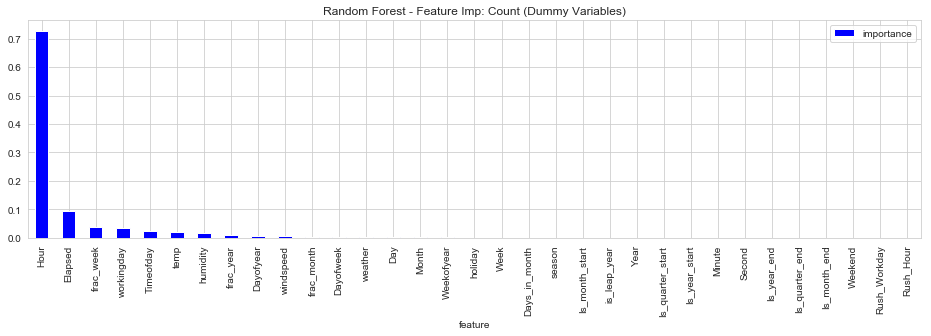

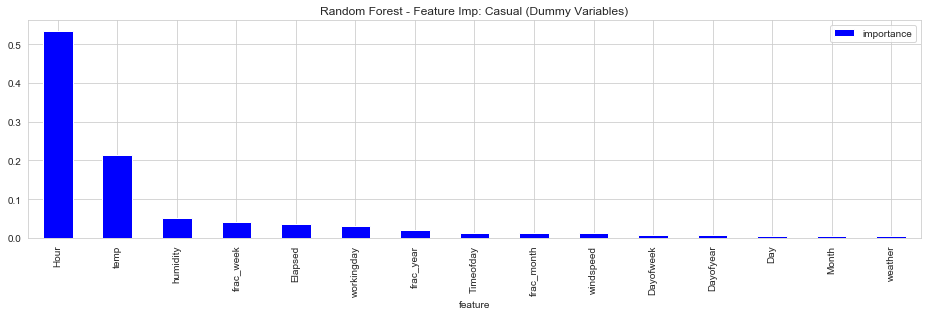

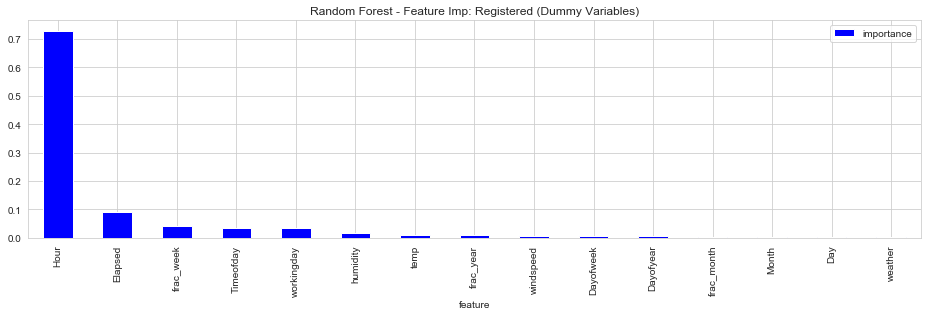

In [54]:
# Visualizing the top features for Random Forest (segm. by count, casual, registered)
rf_model = RandomForestRegressor(n_jobs=-1)

# Calculating the top features for count, casual, registered
rf_feats_count = model_feat_imp(train_on, train_label_cnt, test_on, ALL_IN_FEATS, rf_model, len(ALL_IN_FEATS))
rf_feats_cas = model_feat_imp(train_on, train_label_cas, test_on, ALL_IN_FEATS, rf_model, 15)
rf_feats_reg = model_feat_imp(train_on, train_label_reg, test_on, ALL_IN_FEATS, rf_model, 15)

# Plotting the top feature performerrs
rf_feats_count.plot.bar(color='b', figsize=(16, 4))
plt.title("Random Forest - Feature Imp: Count (Dummy Variables)")
rf_feats_cas.plot.bar(color='b', figsize=(16, 4))
plt.title("Random Forest - Feature Imp: Casual (Dummy Variables)")
rf_feats_reg.plot.bar(color='b', figsize=(16, 4))
plt.title("Random Forest - Feature Imp: Registered (Dummy Variables)")

plt.show()

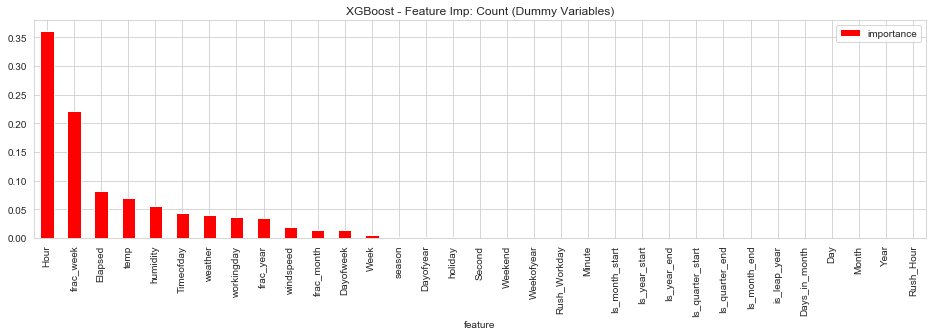

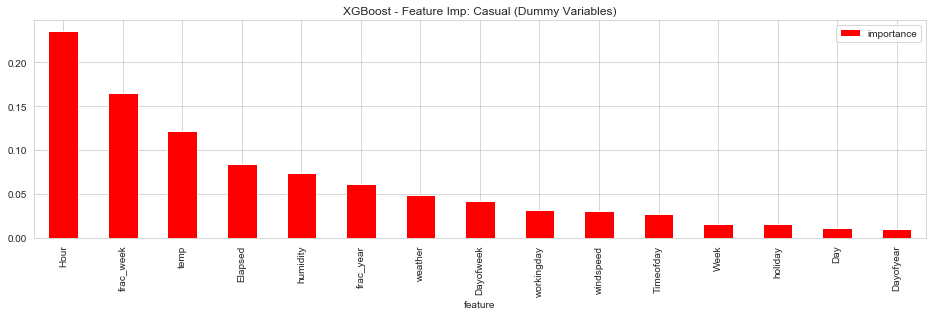

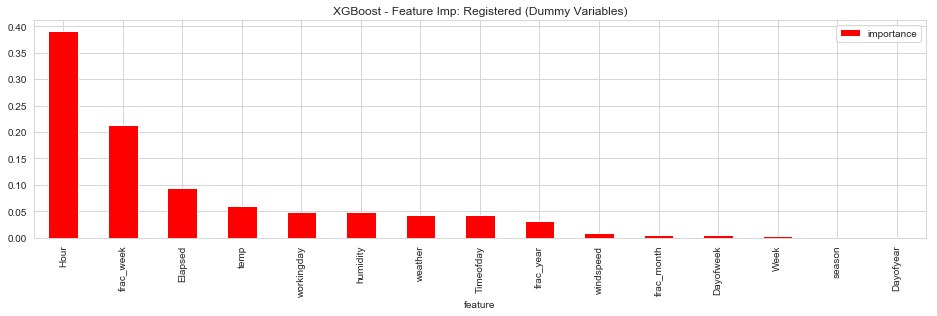

In [55]:
# Visualizing the top features for Xgboost (segm. by count, casual, registered)
xgb_model = xgb.XGBRegressor(n_jobs=-1)

# Calculating the top features for count, casual, registered
xgb_feats_count = model_feat_imp(train_on, train_label_cnt, test_on, ALL_IN_FEATS, xgb_model, len(ALL_IN_FEATS))
xgb_feats_cas = model_feat_imp(train_on, train_label_cas, test_on, ALL_IN_FEATS, xgb_model, 15)
xgb_feats_reg = model_feat_imp(train_on, train_label_reg, test_on, ALL_IN_FEATS, xgb_model, 15)

# Plotting the top feature performerrs
xgb_feats_count.plot.bar(color='r', figsize=(16, 4))
plt.title("XGBoost - Feature Imp: Count (Dummy Variables)")
xgb_feats_cas.plot.bar(color='r', figsize=(16, 4))
plt.title("XGBoost - Feature Imp: Casual (Dummy Variables)")
xgb_feats_reg.plot.bar(color='r', figsize=(16, 4))
plt.title("XGBoost - Feature Imp: Registered (Dummy Variables)")

plt.show()

### Data Modeling: Randomized Grid Search CV

In [53]:
def get_predict(model, train_on, train_labels, test_on, test_ids):
    model.fit(train_on, train_labels)
    
    predict = model.predict(test_on)
    predict = np.exp(predict) - 1
    
    sub = pd.DataFrame({'datetime': test_ids, 'count': predict.astype(int)})
    return sub

In [54]:
def random_search(model, params, train_on, train_labels, cv=5):
    train_on = train_on.values
    rs = RandomizedSearchCV(model, param_distributions=params, scoring=scorer, cv=cv)
    
    # Train the model
    rs.fit(train_on, train_labels)
    return rs

In [ ]:
xgb_model = xgb.XGBRegressor(n_jobs=-1)
xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight": [1, 3, 5, 7],
              "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4],
              "colsample_bytree": [0.3, 0.4, 0.5 , 0.7]}

In [ ]:
# Training with label encoder dataset
xgb_rs = random_search(xgb_model, xgb_params, train_on, train_label_cnt, cv=5)
print(f"Best Params: {xgb_rs.best_params_}")

xgb_model = xgb.XGBRegressor(**xgb_rs.best_params_)
xgb_predicts = get_predict(xgb_model, train_on_dum, train_label_cnt_dum, test_on_dum, test_datetime)#
#xgb_predicts.to_csv("./saved_submissions/xgb_12-18-18.csv", index=False)

# Dataset: train_on, Score: 0.44104

In [70]:
# Training with label encoder dataset
xgb_rs = random_search(xgb_model, xgb_params, train_on_dum, train_label_cnt_dum, cv=5)
print(f"Best Hyperparamters: {xgb_rs.best_params_}")
print(f"Best Score: {np.abs(xgb_rs.best_score_):.2f}")

xgb_model = xgb.XGBRegressor(**xgb_rs.best_params_)
xgb_predicts = get_predict(xgb_model, train_on_dum, train_label_cnt_dum, test_on_dum, test_datetime)
#xgb_predicts.to_csv("./saved_submissions/xgb-dummy_12-18-18.csv", index=False)

# Dataset: train_on_dum, CV=5, Score: 0.43447
# Dataset: train_on_dum, CV=10, Score: 0.43488

Best Hyperparamters: {'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.3500000000000001, 'gamma': 0.6000000000000001, 'colsample_bytree': 0.7}
Best Score: 0.39


#### Scores:
1. Dataset: `train_on`, Scorer: `rmse_log`, cv=5, Score=0.44104
2. Dataset: `train_on_dum`, Scorer: `rmse_log`, cv=5, .43447
3. Dataset: `train_on_dum`, Scorer: `rmse_log`, cv=10, .43488
4. Dataset: `train_on_dum`, Scorer: `rmse`, cv=5, .43355


## Data Techniques: Improving the Score

The goal is to improve the score. There are a couple of methods that I am thinking might work. We can first select the best variables since the model is probably overfitting. We can also split the registered, counts, and casual to create some weighted total.
1. Let's use the `model_feat_imp` a function to calculate the best features for casual, registered, and count! 

In [56]:
def feat_df(feats, cols):
    return pd.DataFrame(feats, index=cols, columns=['importance']).sort_values('importance', ascending=False)

In [70]:
cols = train_on_dum.columns

# Extracting the features for count 
xgb_rs_count = random_search(xgb_model, xgb_params, train_on_dum, train_label_cnt_dum, cv=5)
xgb_model_count = xgb.XGBRegressor(**xgb_rs_count.best_params_)
xgb_model_count.fit(train_on_dum, train_label_cnt_dum)
count_feats = feat_df(xgb_model_count.feature_importances_, cols)

# Extracting the features for registerd 
xgb_rs_cas = random_search(xgb_model, xgb_params, train_on_dum, train_label_cas_dum, cv=5)
xgb_model_cas = xgb.XGBRegressor(**xgb_rs_cas.best_params_)
xgb_model_cas.fit(train_on_dum, train_label_cas_dum)
cas_feats = feat_df(xgb_model_cas.feature_importances_, cols)

# Extracting the features for registered 
xgb_rs_reg = random_search(xgb_model, xgb_params, train_on_dum, train_label_reg_dum, cv=5)
xgb_model_reg = xgb.XGBRegressor(**xgb_rs_reg.best_params_)
xgb_model_reg.fit(train_on_dum, train_label_cas_dum)
reg_feats = feat_df(xgb_model_reg.feature_importances_, cols)


In [71]:
print(f"Best Score (count): {np.abs(xgb_rs_count.best_score_):.2f}")
print(f"Best Score (casual): {np.abs(xgb_rs_cas.best_score_):.2f}")
print(f"Best Score (registered): {np.abs(xgb_rs_reg.best_score_):.2f}")

Best Score (count): 0.41
Best Score (casual): 0.58
Best Score (registered): 0.39


In [72]:
imp_cols_df = pd.concat([count_feats, cas_feats, reg_feats], axis=1)
imp_cols_df.columns = ['imp_count', 'imp_cas', 'imp_reg']
imp_cols_df.sort_index(by='imp_count', ascending=False).head(5)

,imp_count,imp_cas,imp_reg
frac_week,0.148092,0.144290,0.160015
frac_year,0.119478,0.131944,0.120883
Elapsed,0.115713,0.123843,0.103448
Hour,0.089357,0.100309,0.103836
frac_month,0.083584,0.079090,0.082914


In [77]:
imp_cols_df.sort_index(by='imp_count', ascending=False)

,imp_count,imp_cas,imp_reg
frac_week,0.148092,0.144290,0.160015
frac_year,0.119478,0.131944,0.120883
Elapsed,0.115713,0.123843,0.103448
Hour,0.089357,0.100309,0.103836
frac_month,0.083584,0.079090,0.082914
temp,0.073795,0.086806,0.088338
humidity,0.067269,0.063272,0.060054
windspeed,0.042420,0.049769,0.037582
Dayofyear,0.034639,0.031636,0.033320
Week,0.028112,0.027778,0.022859


### Data Modeling: Using `best_features` to improve RMSLE

In [73]:
# Extracting the top columns for the target (count)
imp_cols = imp_cols_df[imp_cols_df['imp_count']>0].index
xgb_rs = random_search(xgb_model, xgb_params, train_on_dum[imp_cols], train_label_cnt_dum, cv=5)

print(f"Best Params: {xgb_rs.best_params_}")

xgb_model = xgb.XGBRegressor(**xgb_rs.best_params_)
xgb_predicts = get_predict(xgb_model, train_on_dum[imp_cols], train_label_cnt_dum, 
                           test_on_dum[imp_cols], test_datetime)
xgb_predicts.to_csv("./saved_submissions/xgb-dummy-featimp_12-21-18.csv", index=False)

# Score -> 0.42954

Best Params: {'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.15, 'gamma': 0.4, 'colsample_bytree': 0.5}


#### Notes:
- The dataframe above us tell us that we do not need many of the variables that were created.
- We will delete it as they could be causing our model to overfit Kaggle's dataset
- Including columns that have important reduced the RMSLE!

#### Scores:
1. Dataset: `train_on_dum`, Scorer: `rmse`, cv=5, Score=0.42954, features=`imp_cols` (extracted them from previous xgb models (feature importances)
    

In [62]:
from sklearn.model_selection import train_test_split

# Split into training and testing data
train, test, train_labels, test_labels = train_test_split(train_on_dum, train_label_cnt_dum, 
                                                          train_size=.7, random_state=50)



In [75]:
train_on_dum[imp_cols].head(5)

,Day,Dayofweek_Monday,Dayofweek_Saturday,Dayofweek_Sunday,Dayofweek_Thursday,Dayofweek_Tuesday,Dayofweek_Wednesday,Dayofyear,Days_in_month,Elapsed,...,humidity,is_leap_year_True,season_spring,season_summer,season_winter,temp,weather_light snow/light rain,weather_mist/cloudy,windspeed,workingday
0,1,0,1,0,0,0,0,1,31,3.502829e+09,...,81,0,1,0,0,9.84,0,0,0.0,0
1,1,0,1,0,0,0,0,1,31,3.502832e+09,...,80,0,1,0,0,9.02,0,0,0.0,0
2,1,0,1,0,0,0,0,1,31,3.502836e+09,...,80,0,1,0,0,9.02,0,0,0.0,0
3,1,0,1,0,0,0,0,1,31,3.502840e+09,...,75,0,1,0,0,9.84,0,0,0.0,0
4,1,0,1,0,0,0,0,1,31,3.502843e+09,...,75,0,1,0,0,9.84,0,0,0.0,0


In [63]:
eval_set = [(train, train_labels), (test, test_labels)]
eval_metric = ["rmse"]
%time xgb_model.fit(train, train_labels, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:3.92471	validation_1-rmse:3.87532
[1]	validation_0-rmse:3.54681	validation_1-rmse:3.49961
[2]	validation_0-rmse:3.20783	validation_1-rmse:3.16337
[3]	validation_0-rmse:2.90467	validation_1-rmse:2.86219
[4]	validation_0-rmse:2.63221	validation_1-rmse:2.59107
[5]	validation_0-rmse:2.38739	validation_1-rmse:2.34894
[6]	validation_0-rmse:2.16948	validation_1-rmse:2.13285
[7]	validation_0-rmse:1.97228	validation_1-rmse:1.93859
[8]	validation_0-rmse:1.79836	validation_1-rmse:1.76592
[9]	validation_0-rmse:1.64121	validation_1-rmse:1.61113
[10]	validation_0-rmse:1.50189	validation_1-rmse:1.47455
[11]	validation_0-rmse:1.37897	validation_1-rmse:1.35331
[12]	validation_0-rmse:1.26826	validation_1-rmse:1.24546
[13]	validation_0-rmse:1.17076	validation_1-rmse:1.14931
[14]	validation_0-rmse:1.08371	validation_1-rmse:1.06479
[15]	validation_0-rmse:1.00711	validation_1-rmse:0.990181
[16]	validation_0-rmse:0.940508	validation_1-rmse:0.926443
[17]	validation_0-rmse:0.881144	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

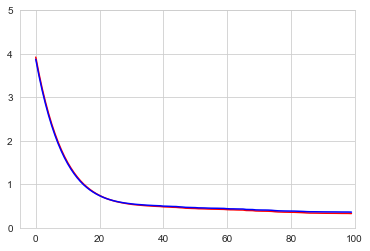

In [102]:
valid_0 = xgb_model.evals_result_['validation_0']['rmse']
valid_1 = xgb_model.evals_result_['validation_1']['rmse']
iters = np.arange(0, len(xgb_model.evals_result_['validation_0']['rmse']), 1)

plt.plot(iters, valid_0, 'r')
plt.plot(iters, valid_1, 'b')
plt.axis([-5, 100, 0, 5])
plt.show()

In [104]:
xgb_model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1}

In [ ]:
xgb_model.best